# Acoustics Analysis

- Vowel analytics

---
- 2021-04-14: first created
    - [x] Plot vowel spaces (points, ellipses, quadrilateral) per speaker/rate
    - [-] Calculate vowel-space/vowel area
- 2021-04-22
    - Run F1, F2 stats
- 2021-04-27
    - updated data (including F3 although not included for stat; Guided PCA with 4D)
- 2021-05-22
    - Duration plot updated
    - Statistical analysis for F3 included

In [1]:
# Basic
import os
import re
import pickle
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

# Visualization
from IPython.display import Image, HTML, display
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# Custom
from tools.utils import *
from tools.plots import *
from tools.postproc import *
from tools.guided_pca import GuidedPCA

rand_seed = 0

## Settings

In [50]:
# --- Settings
save_again = False
use_mel = True
drop_f0 = True # f0 column was dropped because f0 tracking failed for many cases (N>5000).

# --- Directories
data_raw_dir = 'data'
data_proc_dir = 'data_processed'
data_plot_dir = 'data_plots'
stat_dir = 'stats'

# data_file = os.path.join(data_proc_dir, 'data_2021-04-13.csv') # <----- UPDATE HERE
data_file = os.path.join(data_proc_dir, 'data_2021-04-27.csv') # <----- UPDATE HERE

# --- Parameters
spkr_list = ['F01','F02','F03','F04','M01','M02','M03','M04']
vowel_list = ['IY1', 'IH1', 'EH1', 'AO1', 'AH1', 'AA1', 'AE1', 'UH1', 'UW1']
rate_list = ['N','F']
# acous_col = ['F1', 'F2']
acous_col = ['F1', 'F2', 'F3']
artic_col = ['TRx','TRz','TBx','TBz','TTx','TTz','JAWx','JAWz','ULx','ULz','LLx','LLz']
if use_mel:
    acous_col = [c + '_mel' for c in acous_col]
acous_col_norm = [re.sub('_mel', '_norm', ac) for ac in acous_col]
artic_col_norm = [ac+'_norm' for ac in artic_col]
pre_phone_poa = ['bilabial','alveolar','velar']
post_phone_poa = ['bilabial','alveolar','velar']

custom_vowels = ['IY1','IH1','EH1','AE1','AA1','UW1']
num_points = 9
vowel_mid_point = 0.5 # 0~1
corner_vowels = ['IY1', 'AE1', 'AA1', 'UW1']
vowel_label = ['i', 'ɪ', 'ɛ', 'ʌ', 'ɔ', 'ɑ', 'æ', 'ʊ', 'u']

vowel2ipa = {
    'IY1': 'i',
    'IH1': 'ɪ',
    'EH1': 'ɛ',
    'AO1': 'ʌ',
    'AH1': 'ɔ',
    'AA1': 'ɑ',
    'AE1': 'æ',
    'UH1': 'ʊ',
    'UW1': 'u',
}
const_list = ['P','B','T','D','S','K','G','HH']
poa_list = ['bilabial','alveolar','velar','fricative']

# --- Font
# fontpath = '/home/zzandore/.local/share/fonts/Times New Roman 400.ttf'
# prop = font_manager.FontProperties(fname=fontpath)
# matplotlib.rcParams['font.family'] = prop.get_name()
print('Loaded')

Loaded


In [51]:
# Set style (globally)
# sns.set_style("whitegrid", {'font.family' : 'serif' , 'font.serif' : 'Times New Roman'})
# plt.style.use(['science','ieee','no-latex']) # <-- this generates too HIGH quality pics

In [52]:
# Prepare data
D = pd.read_csv(data_file)
D.tail(3)

,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,PreVowelPOA,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
140302,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.062283,0.127111,0.047193,0.040988,-0.027688,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
140303,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,-0.035660,0.105324,-0.037390,0.069666,0.076274,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial
140304,52079,M04_B12_S60_R01_N,M04,12,N,S60,1,COME,K,AH1,...,0.032341,0.138669,-0.149052,0.134113,0.268623,velar,sp,K-AH1-M,C-V1-C,velar-tongue-bilabial


In [53]:
# Load palate
pal_files = sorted(glob(os.path.join(data_raw_dir, '*.pkl')))
pal_all = load_palate(pal_files, spkr_list)
print("Loaded")

Loaded


In [54]:
# Load data parameters
with open(os.path.join(data_proc_dir, 'zscore.pkl'), 'rb') as pckl:
    Z = pickle.load(pckl)
with open(os.path.join(data_proc_dir, 'pca.pkl'), 'rb') as pckl:
    PC = pickle.load(pckl)
VT = pd.read_csv(os.path.join(data_proc_dir, 'vowel_targets.csv'))
GM = pd.read_csv(os.path.join(data_proc_dir, 'grand_means.csv'))
time_list = D.TimeAt.unique().tolist()
print('Loaded')

Loaded


### Summarize vowel durations

In [55]:
# Female speakers
(D.loc[D.Speaker.isin(['F01','F02','F03','F04'])&(D.TimeAt==0.5)&(D.Vowel.isin(['IY1','IH1','EH1','AE1'])), 
       ['Vowel', 'Rate', 'Duration']]
 .groupby(['Vowel', 'Rate'])
 .agg({'Duration': ['mean', 'std']})
)

Duration          
                mean       std
Vowel Rate                    
AE1   F     0.096744  0.035584
      N     0.130522  0.049554
EH1   F     0.073175  0.029986
      N     0.102751  0.043561
IH1   F     0.061574  0.024492
      N     0.082397  0.033379
IY1   F     0.085032  0.030263
      N     0.134237  0.047152

In [56]:
# Male speakers
(D.loc[D.Speaker.isin(['M01','M02','M03','M04'])&(D.TimeAt==0.5)&(D.Vowel.isin(['IY1','IH1','EH1','AE1'])), 
       ['Vowel', 'Rate', 'Duration']]
 .groupby(['Vowel', 'Rate'])
 .agg({'Duration': ['mean', 'std']})
)

Duration          
                mean       std
Vowel Rate                    
AE1   F     0.091096  0.033864
      N     0.134721  0.053988
EH1   F     0.064777  0.026372
      N     0.094275  0.042168
IH1   F     0.057625  0.023275
      N     0.077843  0.034841
IY1   F     0.083984  0.031181
      N     0.136226  0.051506

<h2 style="background-color: yellow;color:black">Vowel plots</h2>

In [10]:
# Define helper functions
def _plot_dur_vowels(df, which_spkr, which_time, custom_vowels, use_serif=False):
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')
    ax1 = plot_duration(ax1, df, which_spkr, custom_vowels, vowel2ipa)
    ax2 = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa)
    # Titles
    ax1.set_title('Duration', fontsize=25)
    ax2.set_title('Normal rate', fontsize=25)
    ax3.set_title('Fast rate', fontsize=25)
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
    fig.suptitle(f'Speaker: {which_spkr}', y=0.9)
    fig.tight_layout()
    return fig, [ax1, ax2, ax3]


def _plot_dur_vowel_spaces(df, which_spkr, which_time, custom_vowels,
                           center_stat='median',
                           show_title=True,
                           ax2_title='Vowel space (ellipses)',
                           ax3_title='Vowel space (quadrilateral)',
                           use_serif=False):
    if use_serif:
        sns.set_style(
            "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})

    fig, (ax1, ax2, ax3) = plt.subplots(
        1, 3, figsize=(18, 5), facecolor='white')
    # --- Duration plot
    ax1 = plot_duration(
        ax1, df.loc[df.Speaker == which_spkr], which_spkr, custom_vowels, vowel2ipa)
    # --- Ellipse plot
    ax2, params_N = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                                 vowel_col='Vowel', vowel_list=custom_vowels,
                                 F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                                 center_only=False,
                                 ellipse_only=True,
                                 ellipse_linestyle='-',
                                 return_params=True,
                                 )
    ax2, params_F = plot_F1F2_df(ax2, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                                 vowel_col='Vowel', vowel_list=custom_vowels,
                                 F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                                 center_only=False,
                                 ellipse_only=True,
                                 ellipse_linestyle='--',
                                 return_params=True,
                                 )
    # Prettify
    l1, = ax2.plot([], [], 'k-', linewidth=2)
    l2, = ax2.plot([], [], 'k--', linewidth=2)
    ax2.legend([l1, l2], ['N', 'F'], fontsize=10)

    # --- Line plot
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'N') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                       center_only=center_stat,
                       connected_linestyle='-',
                       )
    ax3 = plot_F1F2_df(ax3, df.loc[(df.Speaker == which_spkr) & (df.Rate == 'F') & (df.TimeAt == which_time)],
                       vowel_col='Vowel', vowel_list=custom_vowels,
                       F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                       center_only=center_stat,
                       connected_linestyle='--',
                       )
    # Prettify
    l1, = ax3.plot([], [], 'k-', linewidth=2)
    l2, = ax3.plot([], [], 'k--', linewidth=2)
    ax3.legend([l1, l2], ['N', 'F'], fontsize=10)

    # Titles
    ax1.set_title('Duration', fontsize=25, y=1.02)
    ax2.set_title(ax2_title, fontsize=25, y=1.02)
    ax3.set_title(ax3_title, fontsize=25, y=1.02)

    if show_title:
        if use_serif:
            sns.set_style(
                "whitegrid", {'font.family': 'serif', 'font.serif': 'Times New Roman'})
        fig.suptitle(f'Speaker: {which_spkr}', y=0.9)
    fig.tight_layout()
    return fig, [ax1, ax2, ax3], params_N, params_F

In [11]:
# Plot overall duration and formant patterns for checking
which_time = 0.5
# which_vowels = corner_vowels
which_vowels = custom_vowels

params = {spkr:{} for spkr in spkr_list}
for which_spkr in tqdm(spkr_list, total=len(spkr_list)):
    spkr_dir = os.path.join(data_plot_dir, which_spkr, 'vowel_space')
    safe_mkdir(spkr_dir)

    # Vowel data-point plots (data points with ellipses)
    fig, arr = _plot_dur_vowels(D, which_spkr, which_time, which_vowels, use_serif=True)
    if save_again:
        fig.savefig(os.path.join(spkr_dir, f'{which_spkr}_vowel_data_{len(which_vowels)}.png'), bbox_inches='tight')
    plt.close()

    # Vowel space plots (ellipses, quadri-laterals)
    fig, arr, params_N, params_F = _plot_dur_vowel_spaces(D, which_spkr, which_time, which_vowels, use_serif=True)
    if save_again:
        fig.savefig(os.path.join(spkr_dir, f'{which_spkr}_vowel_space_{len(which_vowels)}.png'), bbox_inches='tight')
    plt.close()

    # Update
    params[which_spkr]['normal'] = params_N
    params[which_spkr]['fast'] = params_F
print('Done')

100%|██████████| 8/8 [00:06<00:00,  1.22it/s]

Done


interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

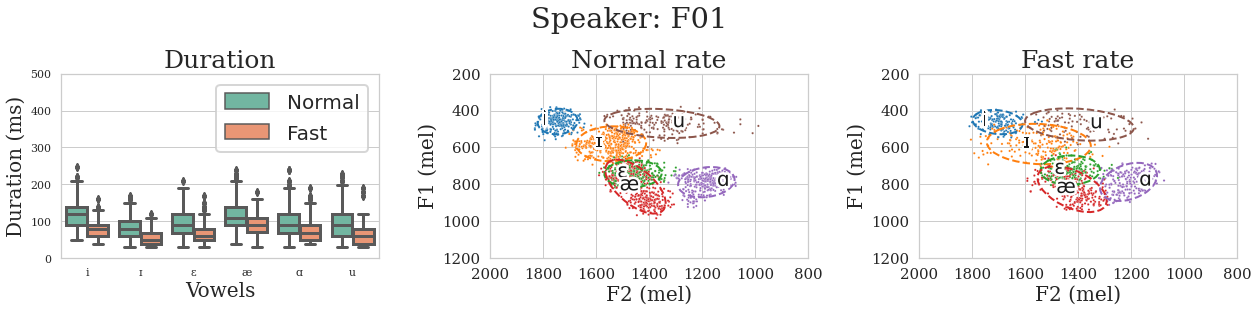

In [9]:
def func1(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, 'vowel_space', 
                                       #f'{which_spkr}_vowel_data_7.png'), 
                                       f'{which_spkr}_vowel_data_6.png'), 
                 width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func1, which_spkr=spkr_dropdown);
func1('F01')

interactive(children=(Dropdown(description='which_spkr', options=('F01', 'F02', 'F03', 'F04', 'M01', 'M02', 'M…

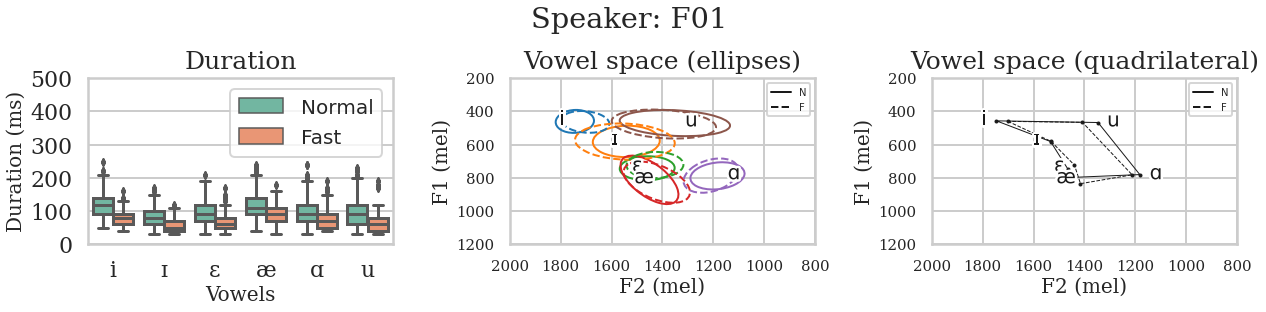

In [10]:
def func2(which_spkr):
    return Image(filename=os.path.join(data_plot_dir, which_spkr, 'vowel_space', 
                                       #f'{which_spkr}_vowel_space_4.png'), 
                                       f'{which_spkr}_vowel_space_6.png'), 
                 width=1000)

spkr_dropdown = widgets.Dropdown(options=spkr_list, value='F01')
interact(func2, which_spkr=spkr_dropdown);
func2('F01')

100%|██████████| 8/8 [00:03<00:00,  2.46it/s]


Done


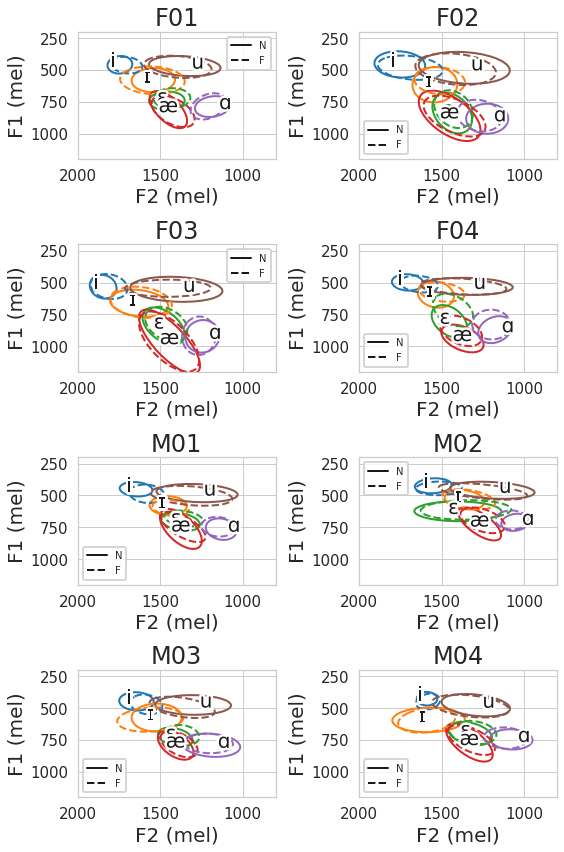

In [11]:
# Make 4x2 plots just for vowel spaces

which_time = 0.5
# which_vowels = corner_vowels
which_vowels = custom_vowels

fig, arr = plt.subplots(4, 2, facecolor='white', figsize=(8, 12))
# spkr_order = ['F01','M01','F02','M02','F03','M03','F04','M04']


for which_spkr, ax in tqdm(zip(spkr_list, arr.flatten()), total=len(spkr_list)):
    spkr_dir = os.path.join(data_plot_dir, which_spkr, 'vowel_space')

    with sns.plotting_context('poster', font_scale=0.8):
        sns.set_style("whitegrid",
                      {'font.family': 'serif', 'font.serif': 'Times New Roman'})
        # --- Ellipse plot
        ax, _ = plot_F1F2_df(ax, D.loc[(D.Speaker == which_spkr) & (D.Rate == 'N') & (D.TimeAt == which_time)],
                             vowel_col='Vowel', vowel_list=custom_vowels,
                             F1_col='F1_mel', F2_col='F2_mel', vowel2ipa=vowel2ipa,
                             center_only=False,
                             ellipse_only=True,
                             ellipse_linestyle='-',
                             return_params=True,
                             sns_context='poster',
                             )
        ax, _ = plot_F1F2_df(ax, D.loc[(D.Speaker == which_spkr) & (D.Rate == 'F') & (D.TimeAt == which_time)],
                             vowel_col='Vowel', vowel_list=custom_vowels,
                             F1_col='F1_mel', F2_col='F2_mel', show_label=False,
                             center_only=False,
                             ellipse_only=True,
                             ellipse_linestyle='--',
                             return_params=True,
                             sns_context='poster',
                             )
        # Prettify
        l1, = ax.plot([], [], 'k-', linewidth=2)
        l2, = ax.plot([], [], 'k--', linewidth=2)
        ax.legend([l1, l2], ['N', 'F'], fontsize=10)
        ax.set_title(which_spkr)

fig.tight_layout()
print('Done')

<h2 style="background-color:yellow;color:black">Vowel areas (space; within)</h2>

### Calculate vowel areas
- vowel space itself
- individual vowels

#### (1) Individual vowel areas

In [12]:
# Calculate individual vowel space area per vowel/speaker/rate
VA = pd.DataFrame(columns=['Speaker','Rate','Vowel','VowelArea','SpaceArea'], 
                  index=range(len(spkr_list)*len(rate_list)*len(custom_vowels)))

i = 0
for which_spkr in spkr_list:
    F1_mu = Z[which_spkr]['acous']['mean']['F1_mel']
    F1_sd = Z[which_spkr]['acous']['std']['F1_mel']
    F2_mu = Z[which_spkr]['acous']['mean']['F2_mel']
    F2_sd = Z[which_spkr]['acous']['std']['F2_mel']

    for which_rate in ['normal', 'fast']:
        rate = 'F' if which_rate=='fast' else 'N'
        for which_vowel in custom_vowels:
            p = params[which_spkr][which_rate][which_vowel]
            
            #norm_x = (p['scale_x'] - F1_mu) / F1_sd # --> THIS IS WRONG
            #norm_y = (p['scale_y'] - F2_mu) / F2_sd # --> THIS IS WRONG
            
            half_width = p['scale_x']
            half_height = p['scale_y']
            
            # Calculate individual vowel area
            vowel_area = np.sqrt(half_width * half_height * np.pi) # apply sqrt to interpret as Hz
            
            VA.at[i, ['Speaker','Rate','Vowel','VowelArea']] = \
                [which_spkr, rate, which_vowel, vowel_area]
            
            i += 1

In [13]:
VA.tail()

,Speaker,Rate,Vowel,VowelArea,SpaceArea
91,M04,F,IH1,228.779854,NaN
92,M04,F,EH1,202.540545,NaN
93,M04,F,AE1,230.02164,NaN
94,M04,F,AA1,183.668284,NaN
95,M04,F,UW1,256.23615,NaN


# 화자별로 individual vowel space넓이를 노멀라이즈 해서 boxplot으로 그릴 것 (2021-04-15 목)

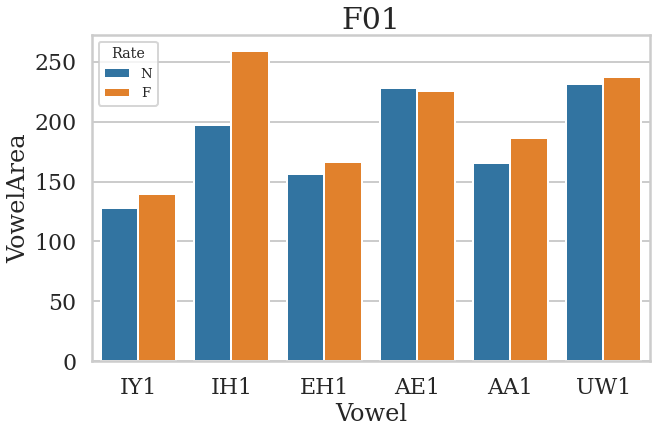

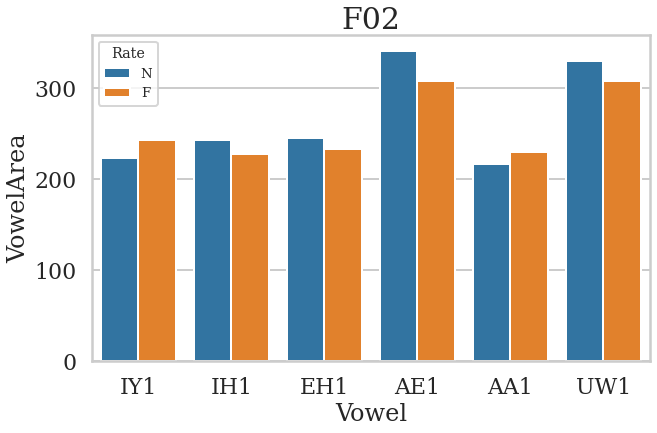

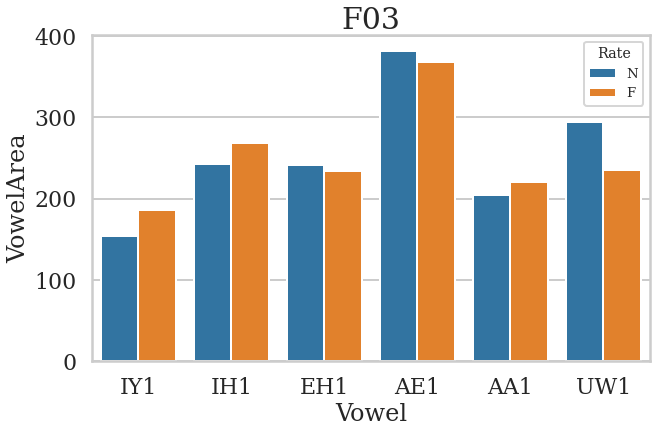

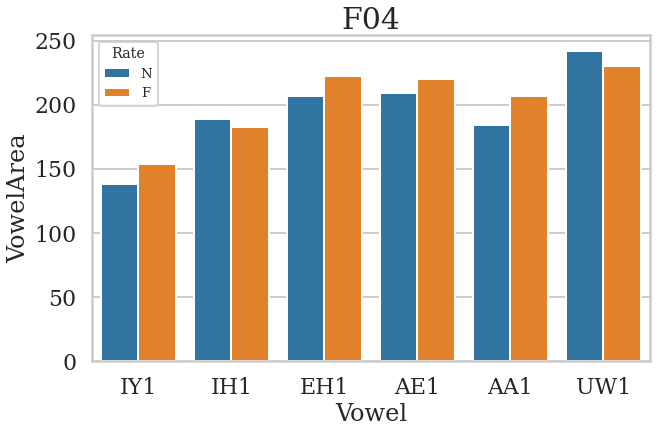

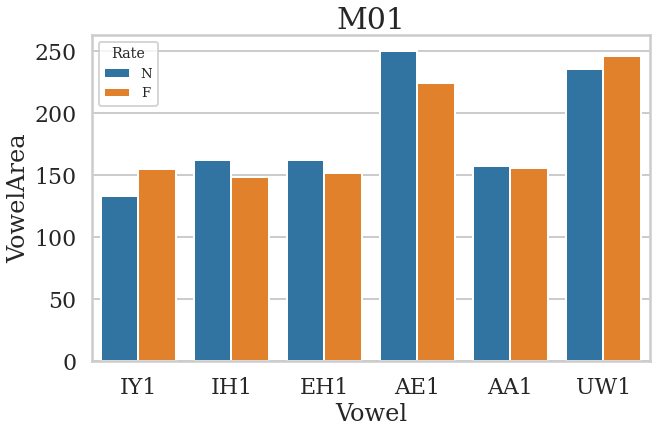

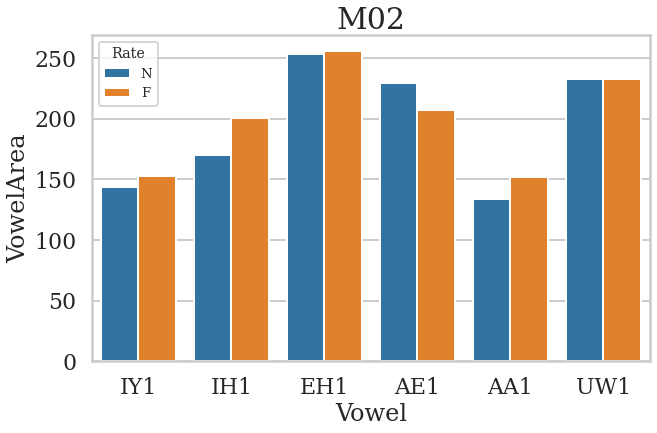

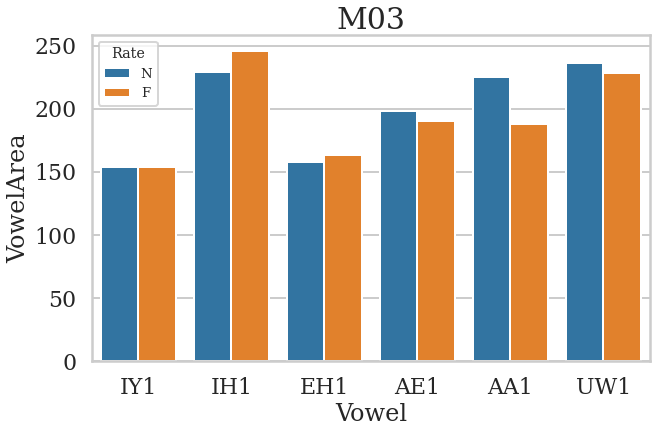

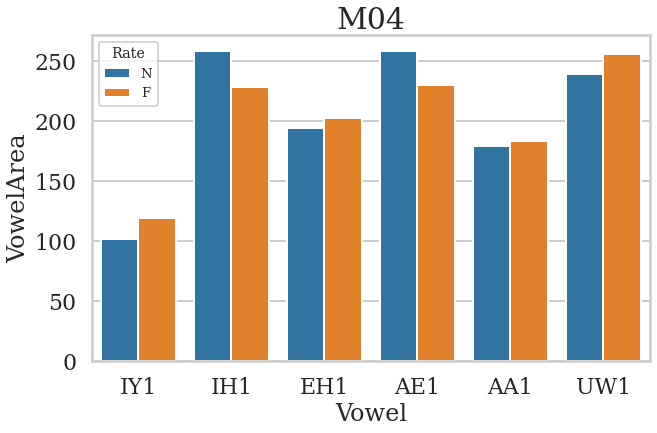

In [15]:
for which_spkr in spkr_list:
    fig, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
    with sns.plotting_context('poster', font_scale=0.6):
        sns.barplot(ax=ax, x='Vowel', y='VowelArea', hue='Rate', data=VA[VA.Speaker==which_spkr])
        ax.set_title(f'{which_spkr}', fontsize=30)

#### (2) Vowel space areas

In [16]:
# Calculate vowel space area per speaker/rate
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))

In [30]:
custom_vowels

['IY1', 'IH1', 'EH1', 'AE1', 'AA1', 'UW1']

In [41]:
for which_spkr in spkr_list:
    for which_rate in rate_list:
        
        d = D.loc[(D.Speaker==which_spkr)&(D.Rate==which_rate)&(D.Vowel.isin(custom_vowels)), 
                  #acous_col,
                  ['Vowel'] + acous_col_norm
                 ]
        d = d.groupby(['Vowel']).agg({'F1_norm': 'mean', 'F2_norm': 'mean'}).reset_index()
        #xs, ys = d['F1_mel'].values, d['F2_mel'].values
        xs, ys = d['F1_norm'].values, d['F2_norm'].values
        
        space_area = np.sqrt(PolyArea(xs, ys))
        
        VA.loc[(VA.Speaker==which_spkr)&(VA.Rate==which_rate), ['SpaceArea']] = space_area

In [48]:
VA.groupby(['Speaker','Rate','SpaceArea']).describe().reset_index()

Speaker Rate SpaceArea Vowel                  VowelArea                     \
                          count unique  top freq     count unique         top   
0      F01    F  0.953699     6      6  AA1    1       6.0    6.0  225.284713   
1      F01    N  1.020727     6      6  AA1    1       6.0    6.0  228.486220   
2      F02    F  0.793088     6      6  AA1    1       6.0    6.0  233.651401   
3      F02    N  1.011867     6      6  AA1    1       6.0    6.0  341.324072   
4      F03    F  0.926271     6      6  AA1    1       6.0    6.0  368.288100   
5      F03    N  1.019186     6      6  AA1    1       6.0    6.0  241.975091   
6      F04    F  0.772382     6      6  AA1    1       6.0    6.0  230.164604   
7      F04    N  0.951417     6      6  AA1    1       6.0    6.0  184.335001   
8      M01    F  0.808104     6      6  AA1    1       6.0    6.0  155.905935   
9      M01    N  0.992157     6      6  AA1    1       6.0    6.0  235.249865   
10     M02    F  0.653967     6      6  AA1    1       6.0    6.0  200.519570   
11     M02    N  0.772221     6      6  AA1    1       6.0    6.0  144.038772   
12     M03    F  0.706905     6      6  AA1    1       6.0    6.0  153.714794   
13     M03    N  0.759704     6      6  AA1    1       6.0    6.0  157.809735   
14     M04    F  0.698320     6      6  AA1    1       6.0    6.0  256.236150   
15     M04    N  0.841217     6      6  AA1    1       6.0    6.0  239.791754   

         
   freq  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  
5   1.0  
6   1.0  
7   1.0  
8   1.0  
9   1.0  
10  1.0  
11  1.0  
12  1.0  
13  1.0  
14  1.0  
15  1.0

### 화자별 Vowel space area

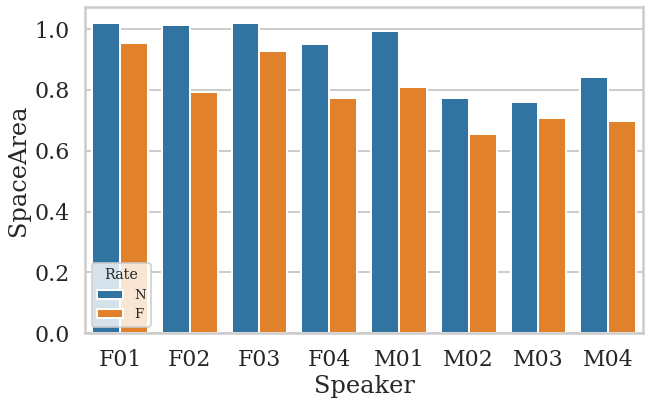

In [49]:
fig, ax = plt.subplots(1, figsize=(10,6), facecolor='white')
with sns.plotting_context('poster', font_scale=0.6):
    sns.barplot(ax=ax, x='Speaker', y='SpaceArea', hue='Rate', data=VA)

---

## Descriptive Analysis
- Speaker X Rate X F1
- Speaker X Rate X F2
- Table summarizing F1, F2 across speaker, rate, context

In [57]:
# Choose vowel mid-point
d = D.loc[D.TimeAt==0.5, ['Speaker','Rate','Vowel','PreVowelPOA']+acous_col]
d = d.loc[D.PreVowelPOA.isin(['bilabial','alveolar','velar'])].reset_index(drop=True)
d = d.rename(columns={'PreVowelPOA':'Context'})
print('shape', d.shape)
    
d.head()

shape (16886, 7)


,Speaker,Rate,Vowel,Context,F1_mel,F2_mel,F3_mel
0,F01,F,UW1,alveolar,534.149186,1538.951736,1804.641749
1,F01,F,UW1,bilabial,443.106992,1274.721368,1714.853020
2,F01,N,UW1,alveolar,518.052586,1409.179363,1759.057022
3,F01,N,AA1,alveolar,770.610916,1170.500893,1501.600341
4,F01,N,UW1,bilabial,477.324529,1379.641061,1713.606047


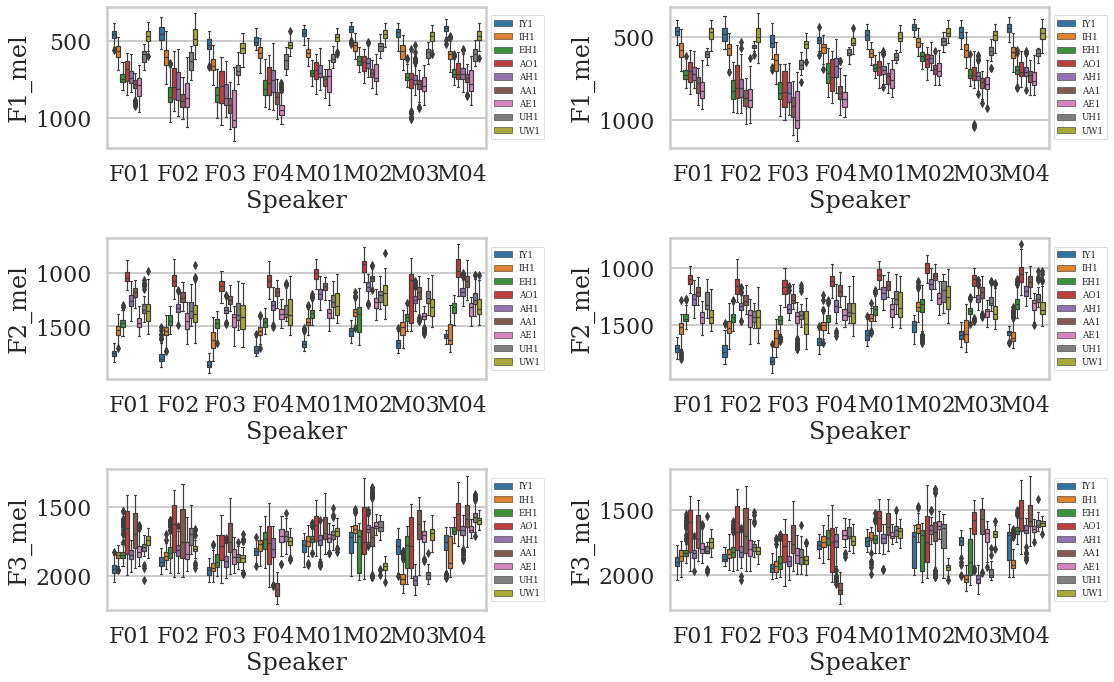

In [63]:
# palette = sns.color_palette('tab10', len(rate_list))
palette = sns.color_palette('tab10', len(vowel_list))

fig, arr = plt.subplots(3, 2, facecolor='white', figsize=(16,10))
with sns.plotting_context('paper', font_scale=1):
    for i, which_col in enumerate(acous_col):
        # ----- Normal rate (left)
        ax = arr[i, 0]
        sns.boxplot(ax=ax, data=d.loc[d.Rate=='N'], 
                    x='Speaker', y=which_col, hue='Vowel', hue_order=vowel_list, 
                    palette=palette)
        #ax1.set_ylim([200, 1300])
        ax.invert_yaxis()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

        # ----- Fast rate (right)
        ax = arr[i, 1]
        sns.boxplot(ax=ax, data=d.loc[d.Rate=='F'], 
                    x='Speaker', y=which_col, hue='Vowel', hue_order=vowel_list, 
                    palette=palette)
        #ax2.set_ylim([600, 2000])
        ax.invert_yaxis()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
fig.tight_layout()

---

## Inferential Statistics on F1, F2 and F3
- See: `Articulatory-Data-Processor/_1-03_stat_acous.ipynb`

In [64]:
%load_ext rpy2.ipython

In [65]:
%%R
# Stat
library(car)
library(stats)
library(lme4)
library(emmeans)

# Plotting
library(ggplot2)
library(ggeffects)
library(ggpubr)
library(sjPlot)

R[write to console]: Loading required package: carData

R[write to console]: Loading required package: Matrix

R[write to console]: Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

R[write to console]: #refugeeswelcome



In [66]:
%%capture
%%R
par(family  = "Arial")
install.packages("showtext")
library(showtext)
showtext_auto()

## COV: coefficients of variation

In [67]:
# d = D[['Speaker','Vowel','PreVowelPOA','Rate','F1_mel','F2_mel']].reset_index(drop=True)
# d = (d.groupby(['Speaker','Vowel','Context','Rate'])
#      .agg(['mean','std'])
#      .reset_index()
#     )

# d['F1_CV'] = d['F1_mel']['std']/d['F1_mel']['mean'] * 100
# d['F2_CV'] = d['F2_mel']['std']/d['F2_mel']['mean'] * 100
# d = d[['Speaker','Vowel','Context','Rate','F1_CV','F2_CV']].reset_index(drop=True)
# d.columns = ['Speaker','Vowel','Context','Rate','F1_CV','F2_CV']

In [68]:
# %%R -i d
# d$Rate = as.factor(d$Rate)
# d$Vowel = as.factor(d$Vowel)
# d$Speaker = as.factor(d$Speaker)
# d$PreVowelPOA = as.factor(d$PreVowelPOA)

# d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1", "AA1", "AH1", "AO1", "UW1"))
# d$PreVowelPOA = ordered(d$PreVowelPOA, levels=c("bilabial","alveolar","velar"))

# cov.F1 = lmer(F1_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# # summary(cov.F1)
# Anova(cov.F1, type=3)

In [69]:
# %%R
# cov.F2 = lmer(F2_CV ~ Rate*PreVowelPOA*Vowel + (1|Speaker), data=d)
# # summary(cov.F1)
# Anova(cov.F2, type=3)

In [70]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), facecolor='white', sharey=True)

# with sns.plotting_context('paper'):
#     sns.violinplot(ax=ax1, x='Vowel', y='F1_CV', hue='Rate', 
#                    order=vowel_list, hue_order=['N','F'], data=d)
#     sns.violinplot(ax=ax2, x='Vowel', y='F2_CV', hue='Rate', 
#                    order=vowel_list, hue_order=['N','F'], data=d)
    
#     ax1.set_title('F1 CV (%)', fontsize=30, y=1.02)
#     ax2.set_title('F2 CV (%)', fontsize=30, y=1.02)
#     ax1.set_ylabel('')
#     ax2.set_ylabel('')
#     ax1.set_xticklabels([vowel2ipa[v] for v in vowel_list])
#     ax2.set_xticklabels([vowel2ipa[v] for v in vowel_list])
#     fig.tight_layout()

## LME model when DV:F1

In [28]:
# Choose vowel mid-point
d = D.loc[D.TimeAt==0.5]
d = d.loc[D.PreVowelPOA.isin(['bilabial','alveolar','velar'])].reset_index(drop=True)
d = d.rename(columns={'PreVowelPOA':'Context'})
print('shape', d.shape)
    
d.head(3)

shape (16886, 59)


,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,Context,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
0,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.333751,0.089203,-0.161451,0.158579,0.414875,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,3,F01_B01_S01_R01_F,F01,1,F,S01,1,SMOOTH,M,UW1,...,0.116710,0.172040,-0.100575,0.260112,0.558068,bilabial,sp,S-M-UW1-DH,C-C-V1-C,alveolar-bilabial-tongue-interdental
2,5,F01_B01_S01_R01_N,F01,1,N,S01,1,CANOE,N,UW1,...,0.177846,0.062894,-0.079544,0.052303,0.269218,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue


In [75]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$PreVowel = as.factor(d$PreVowel)
d$Speaker = as.factor(d$Speaker)
d$Block = as.factor(d$Block)
d$Token = as.factor(d$Token)
d$Context = as.factor(d$Context)

# d$Rate <- ordered(d$Rate, levels = c("N","F"))
d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1"))
d$Context = ordered(d$Context, levels=c("bilabial","alveolar","velar"))

In [76]:
%%R
m.F1 = lmer(F1_norm ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.F1)

Linear mixed model fit by REML ['lmerMod']
Formula: F1_norm ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 287.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-4.3777 -0.6285  0.0080  0.6229  3.5859 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.001941 0.04405 
 Residual             0.059342 0.24360 
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                         Estimate Std. Error t value
(Intercept)              0.069385   0.016831   4.123
RateN                    0.033157   0.008241   4.023
Context.L               -0.045799   0.012778  -3.584
Context.Q               -0.006645   0.008972  -0.741
Vowel.L                  0.975805   0.014909  65.450
Vowel.Q                 -0.029773   0.012754  -2.334
Vowel.C                 -0.068235   0.010144  -6.727
RateN:Context.L          0.008408   0.016560   0.508
RateN:Context.Q          0.027407   0.011543   2.374
RateN:Vowel.L           

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [77]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.F1, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F1_norm
                       Chisq Df Pr(>Chisq)    
(Intercept)          16.9954  1  3.747e-05 ***
Rate                 16.1872  1  5.738e-05 ***
Context              15.0314  2  0.0005445 ***
Vowel              6225.6956  3  < 2.2e-16 ***
Rate:Context          6.5808  2  0.0372394 *  
Rate:Vowel           31.2604  3  7.492e-07 ***
Context:Vowel        63.3506  6  9.363e-12 ***
Rate:Context:Vowel   17.3934  6  0.0079413 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [78]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.F1 = emmeans(m.F1, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F1)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N      0.0539 0.0257 Inf  2.098  0.0359 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0369 0.0122 Inf -3.028  0.0025 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0952 0.0121 Inf -7.890  <.0001 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0544 0.0115 Inf -4.730  <.0001 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [79]:
%%R
em.F1_ = emmeans(m.F1, ~ Rate|Context, adjust = "tukey")
pairs(em.F1_)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0384 0.00953 Inf -4.031  0.0001 

Context = alveolar:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0108 0.00792 Inf -1.361  0.1735 

Context = velar:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0503 0.02139 Inf -2.351  0.0187 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [80]:
%%R
em.F1.poa = emmeans(m.F1, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.F1.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.05840 0.0215 Inf  2.719  0.0065 

Context = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.06156 0.0153 Inf  4.022  0.0001 

Context = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.04172 0.0724 Inf  0.576  0.5646 

Context = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.03026 0.0221 Inf -1.371  0.1703 

Context = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00116 0.0158 Inf -0.074  0.9414 

Context = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.07938 0.0245 Inf -3.237  0.0012 

Context = bilabial, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.10115 0.0162 Inf -6.227  <.0001 

Context = alveolar, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.11175 0.0140 Inf -7.995  <.0001 

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



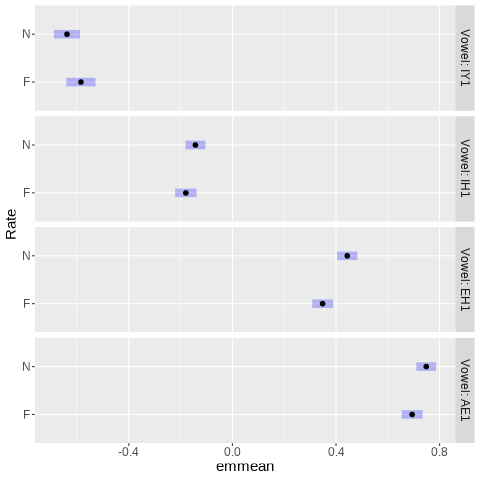

In [81]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.F1, by = "Vowel", intervals = TRUE, type = "response")

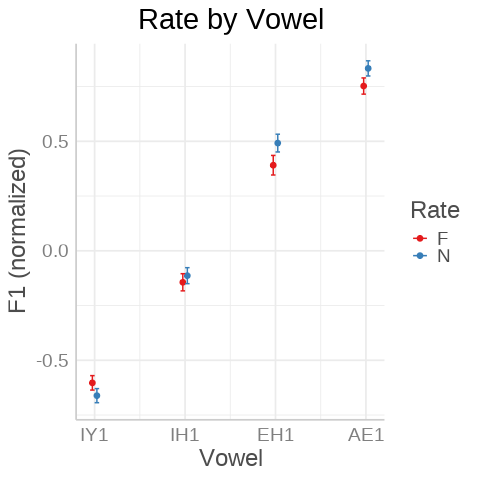

In [82]:
%%R
plot_model(m.F1, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") + 
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab('F1 (normalized)')

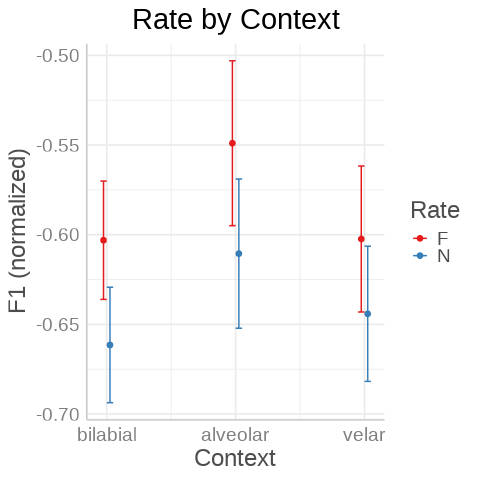

In [83]:
%%R
plot_model(m.F1, type = "pred", terms = c("Context", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab('F1 (normalized)')

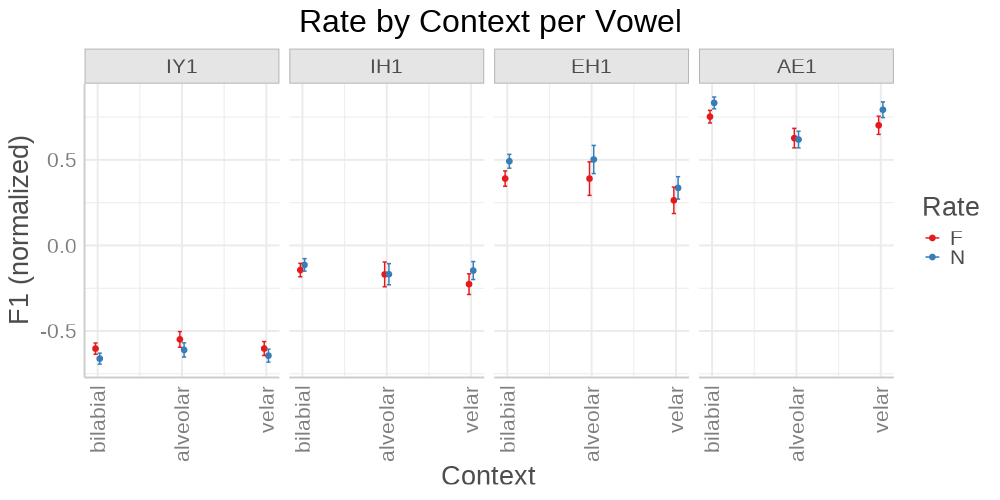

In [84]:
%%R -w 1000 -h 500
plot_model(m.F1, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab('F1 (normalized)')

### LME model when DV:F2

In [85]:
%%R
m.F2 = lmer(F2_norm ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.F2)

Linear mixed model fit by REML ['lmerMod']
Formula: F2_norm ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 3433.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.8183 -0.6788 -0.0750  0.5850  4.7588 

Random effects:
 Groups   Name        Variance  Std.Dev.
 Speaker  (Intercept) 0.0004773 0.02185 
 Residual             0.0867296 0.29450 
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              0.3538116  0.0109149  32.416
RateN                    0.0795220  0.0099626   7.982
Context.L                0.0201446  0.0154476   1.304
Context.Q               -0.0057214  0.0108460  -0.528
Vowel.L                 -0.7564659  0.0180236 -41.971
Vowel.Q                  0.2349196  0.0154173  15.237
Vowel.C                  0.0742745  0.0122621   6.057
RateN:Context.L          0.0042882  0.0200194   0.214
RateN:Context.Q         -0.0003107  0.0139534  -0.022
RateN:Vowe

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [86]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.F2, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F2_norm
                       Chisq Df Pr(>Chisq)    
(Intercept)        1050.7665  1  < 2.2e-16 ***
Rate                 63.7128  1  1.439e-15 ***
Context               3.9290  2     0.1402    
Vowel              2163.7788  3  < 2.2e-16 ***
Rate:Context          0.0746  2     0.9634    
Rate:Vowel           27.5157  3  4.590e-06 ***
Context:Vowel        30.1388  6  3.699e-05 ***
Rate:Context:Vowel    8.3797  6     0.2116    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [87]:
%%R
em.F2 = emmeans(m.F2, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F2)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1518 0.0311 Inf -4.889  <.0001 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0323 0.0147 Inf -2.192  0.0284 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.1060 0.0146 Inf -7.269  <.0001 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0279 0.0139 Inf -2.009  0.0446 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [88]:
%%R
em.F2_ = emmeans(m.F2, ~ Rate|Context, adjust = "tukey")
pairs(em.F2_)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0764 0.01152 Inf -6.630  <.0001 

Context = alveolar:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0798 0.00957 Inf -8.332  <.0001 

Context = velar:
 contrast estimate      SE  df z.ratio p.value
 F - N     -0.0824 0.02586 Inf -3.187  0.0014 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [89]:
%%R
em.F2.poa = emmeans(m.F2, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.F2.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.15763 0.0260 Inf  -6.071 <.0001 

Context = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.19163 0.0185 Inf -10.355 <.0001 

Context = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.10621 0.0875 Inf  -1.213 0.2251 

Context = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00639 0.0267 Inf  -0.240 0.8107 

Context = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.01542 0.0191 Inf  -0.806 0.4201 

Context = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.07517 0.0296 Inf  -2.536 0.0112 

Context = bilabial, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.10713 0.0196 Inf  -5.455 <.0001 

Context = alveolar, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.07251 0.0169 Inf  -4.291 <.0001 

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



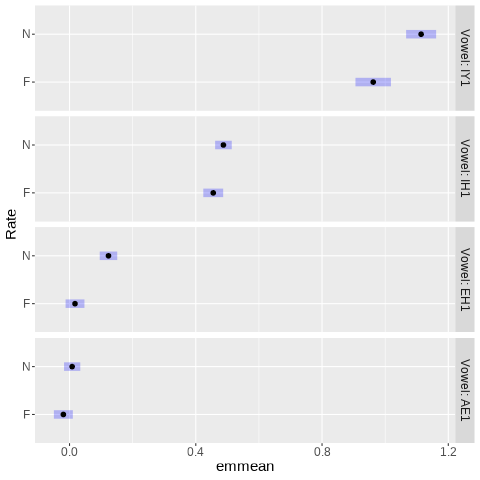

In [90]:
%%R
plot(em.F2, by = "Vowel", intervals = TRUE, type = "response")

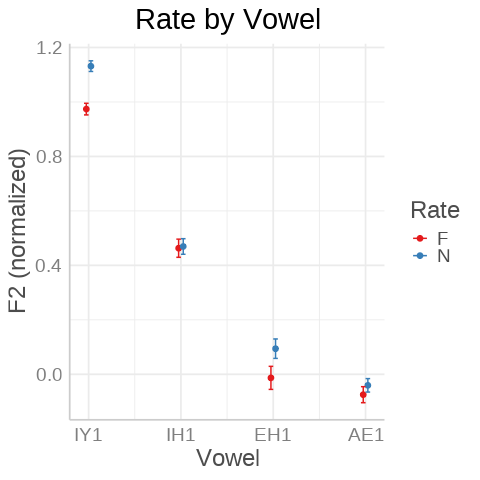

In [91]:
%%R
plot_model(m.F2, type='pred', terms=c("Vowel","Rate")) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab('F2 (normalized)')

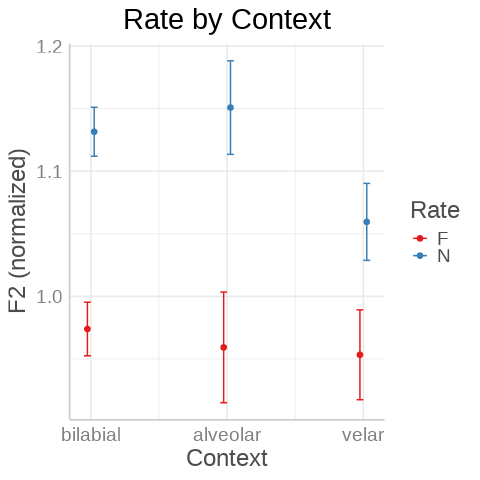

In [92]:
%%R
plot_model(m.F2, type = "pred", terms = c("Context", "Rate")) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab('F2 (normalized)')

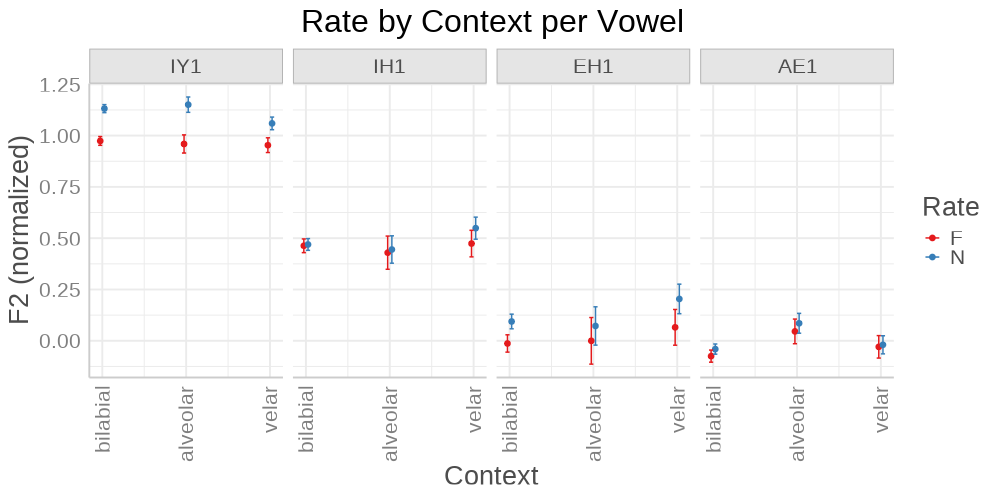

In [93]:
%%R -w 1000 -h 500
plot_model(m.F2, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab('F2 (normalized)')

### LME model when DV:F3

In [73]:
# Choose vowel mid-point
d = D.loc[D.TimeAt==0.5]
d = d.loc[D.PreVowelPOA.isin(['bilabial','alveolar','velar'])].reset_index(drop=True)
d = d.rename(columns={'PreVowelPOA':'Context'})
print('shape', d.shape)
    
d.head(3)

shape (16886, 59)


,Token,FileID,Speaker,Block,Rate,Sent,Rep,Word,PreVowel,Vowel,...,JAWz_norm,ULx_norm,ULz_norm,LLx_norm,LLz_norm,Context,PostVowelPOA,Pronunciation,Tag,PlaceOfArticulation
0,0,F01_B01_S01_R01_F,F01,1,F,S01,1,CANOE,N,UW1,...,0.333751,0.089203,-0.161451,0.158579,0.414875,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue
1,3,F01_B01_S01_R01_F,F01,1,F,S01,1,SMOOTH,M,UW1,...,0.116710,0.172040,-0.100575,0.260112,0.558068,bilabial,sp,S-M-UW1-DH,C-C-V1-C,alveolar-bilabial-tongue-interdental
2,5,F01_B01_S01_R01_N,F01,1,N,S01,1,CANOE,N,UW1,...,0.177846,0.062894,-0.079544,0.052303,0.269218,alveolar,sp,K-AH0-N-UW1,C-V0-C-V1,velar-tongue-alveolar-tongue


In [74]:
%%R -i d
d$Rate = as.factor(d$Rate)
d$Vowel = as.factor(d$Vowel)
d$PreVowel = as.factor(d$PreVowel)
d$Speaker = as.factor(d$Speaker)
d$Block = as.factor(d$Block)
d$Token = as.factor(d$Token)
d$Context = as.factor(d$Context)

# d$Rate <- ordered(d$Rate, levels = c("N","F"))
d$Vowel <- ordered(d$Vowel, levels = c("IY1", "IH1", "EH1", "AE1"))
d$Context = ordered(d$Context, levels=c("bilabial","alveolar","velar"))

In [75]:
%%R
m.F3 = lmer(F3_norm ~ Rate*Context*Vowel + (1|Speaker), data=d)
summary(m.F3)

Linear mixed model fit by REML ['lmerMod']
Formula: F3_norm ~ Rate * Context * Vowel + (1 | Speaker)
   Data: d

REML criterion at convergence: 5166.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.7893 -0.6487 -0.0711  0.5174  4.0452 

Random effects:
 Groups   Name        Variance Std.Dev.
 Speaker  (Intercept) 0.06494  0.2548  
 Residual             0.10641  0.3262  
Number of obs: 8344, groups:  Speaker, 8

Fixed effects:
                          Estimate Std. Error t value
(Intercept)              0.0336769  0.0905011   0.372
RateN                    0.0596392  0.0110359   5.404
Context.L               -0.0205777  0.0171112  -1.203
Context.Q               -0.0333855  0.0120140  -2.779
Vowel.L                 -0.2799793  0.0199650 -14.023
Vowel.Q                 -0.1206207  0.0170787  -7.063
Vowel.C                  0.0491509  0.0135834   3.618
RateN:Context.L         -0.0026090  0.0221754  -0.118
RateN:Context.Q         -0.0020048  0.0154570  -0.130
RateN:Vowel.L

R[write to console]: 
Correlation matrix not shown by default, as p = 24 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it




In [76]:
%%R
# Use anova to assess whether the factor as a whole is explanatory
Anova(m.F3, type=3)

Analysis of Deviance Table (Type III Wald chisquare tests)

Response: F3_norm
                      Chisq Df Pr(>Chisq)    
(Intercept)          0.1385  1    0.70981    
Rate                29.2043  1  6.513e-08 ***
Context              7.8768  2    0.01948 *  
Vowel              522.2366  3  < 2.2e-16 ***
Rate:Context         0.0198  2    0.99013    
Rate:Vowel          10.7819  3    0.01297 *  
Context:Vowel       12.9362  6    0.04406 *  
Rate:Context:Vowel   8.3888  6    0.21098    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [77]:
%%R
# emm_options(pbkrtest.limit = 89315)
em.F3 = emmeans(m.F3, ~ Rate|Vowel, adjust = "tukey")
pairs(em.F3)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0928 0.0344 Inf -2.698  0.0070 

Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0219 0.0163 Inf -1.339  0.1805 

Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0370 0.0162 Inf -2.291  0.0219 

Vowel = AE1:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0868 0.0154 Inf -5.639  <.0001 

Results are averaged over the levels of: Context 
Degrees-of-freedom method: asymptotic 


In [78]:
%%R
em.F3_ = emmeans(m.F3, ~ Rate|Context, adjust = "tukey")
pairs(em.F3_)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



Context = bilabial:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0607 0.0128 Inf -4.755  <.0001 

Context = alveolar:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0613 0.0106 Inf -5.777  <.0001 

Context = velar:
 contrast estimate     SE  df z.ratio p.value
 F - N     -0.0570 0.0286 Inf -1.989  0.0467 

Results are averaged over the levels of: Vowel 
Degrees-of-freedom method: asymptotic 


In [79]:
%%R
em.F3.poa = emmeans(m.F3, ~ Rate|Context|Vowel, adjust = "tukey")
pairs(em.F3.poa)

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'pbkrtest.limit = 8344' (or larger)
[or, globally, 'set emm_options(pbkrtest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.

R[write to console]: Note: D.f. calculations have been disabled because the number of observations exceeds 3000.
To enable adjustments, add the argument 'lmerTest.limit = 8344' (or larger)
[or, globally, 'set emm_options(lmerTest.limit = 8344)' or larger];
but be warned that this may result in large computation time and memory use.



Context = bilabial, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.12245 0.0288 Inf -4.258  <.0001 

Context = alveolar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.12708 0.0205 Inf -6.200  <.0001 

Context = velar, Vowel = IY1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.02894 0.0970 Inf -0.298  0.7654 

Context = bilabial, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00293 0.0296 Inf -0.099  0.9211 

Context = alveolar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N     0.00291 0.0212 Inf  0.137  0.8907 

Context = velar, Vowel = IH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.06562 0.0328 Inf -1.998  0.0457 

Context = bilabial, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.05524 0.0218 Inf -2.539  0.0111 

Context = alveolar, Vowel = EH1:
 contrast estimate     SE  df z.ratio p.value
 F - N    -0.00837 0.0187 Inf -0.447  0.6548 

R[write to console]: Note: adjust = "tukey" was changed to "sidak"
because "tukey" is only appropriate for one set of pairwise comparisons



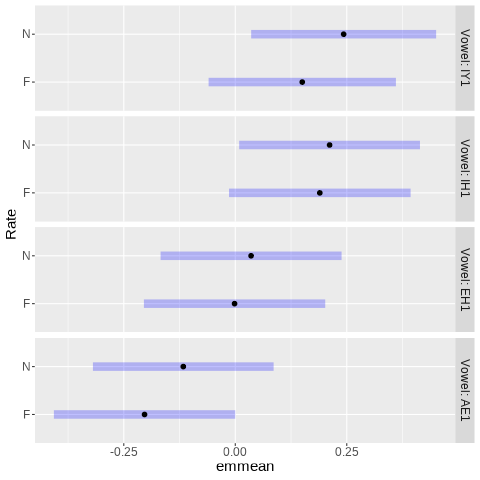

In [80]:
%%R
cex <- 1.7
par(cex.lab=cex, cex.axis=cex, cex.main=cex)
plot(em.F3, by = "Vowel", intervals = TRUE, type = "response")

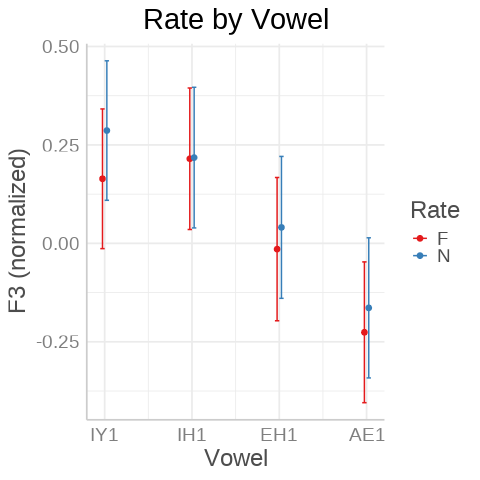

In [81]:
%%R
plot_model(m.F3, type='pred', terms=c("Vowel","Rate"), 
           show.values = TRUE, show.p = TRUE, p.shape = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") + 
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Vowel') +
    ylab('F3 (normalized)')

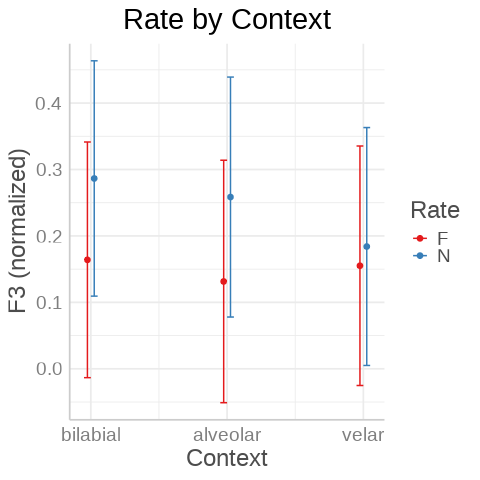

In [82]:
%%R
plot_model(m.F3, type = "pred", terms = c("Context", "Rate"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context') +
    ylab('F3 (normalized)')

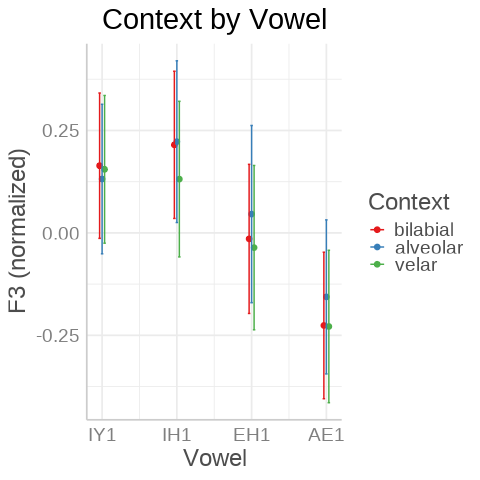

In [85]:
%%R
plot_model(m.F3, type = "pred", terms = c("Vowel", "Context"), show.values = TRUE) +
    theme_sjplot(base_size = 18, base_family = "") +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Context by Vowel') +
    ylab('F3 (normalized)')

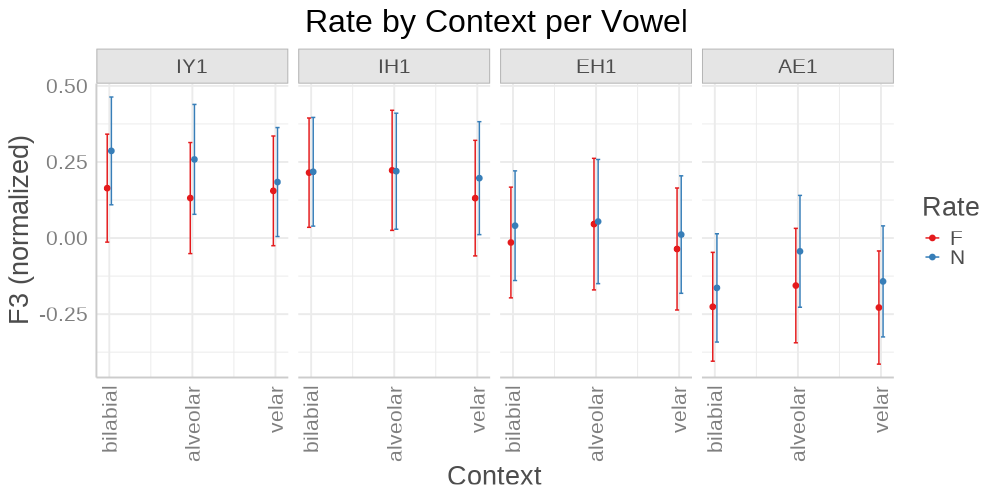

In [83]:
%%R -w 1000 -h 500
plot_model(m.F3, type = "pred", terms = c("Context", "Rate", "Vowel"), show.values = TRUE) +
    facet_wrap(~facet, ncol = 8) +
    theme_sjplot(base_size = 20, base_family = "") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    theme(plot.title = element_text(hjust = 0.5)) +
    ggtitle('Rate by Context per Vowel') +
    ylab('F3 (normalized)')